Codigo donde haremos el analisis exploratorio de los datos para elegir aquellos que utilizaremos en nuestro sistema de recomendacion de peliculas con el modelo de similitud de coseno, ejecutaremos el modelo y crearemos el dataset con las 5 peliculas recomendadas por titulo

In [1]:
import pandas as pd

# Configuración para mostrar todas las filas
pd.set_option('display.max_rows', None)

In [2]:
#Creamos una funcion para evaluar tipo de datos, porcentaje de nulos y cantidad de valores unicos en el dataset
def resumen(df):
    print(f'data shape: {df.shape}')
    resumen = pd.DataFrame(df.dtypes, columns=['data type'])
    resumen['#missing'] = df.isnull().sum()
    resumen['%missing'] = df.isnull().sum()*100/len(df)
    resumen['#unique'] = df.nunique()
    return resumen

In [3]:
#Cargaremos el dataset Movies ya desanidado en la notebook MS_transformaciones, con el cual trabajaremos para el sistema de recomendacion
df_movies = pd.read_parquet('../Datasets/df_movies_desanidado.parquet')

In [4]:
#Utilizamos la funcion Resumen para explorar los datos
resumen(df_movies)

data shape: (419588, 20)


,data type,#missing,%missing,#unique
budget,int64,0,0.000000,1223
movie_id,float64,0,0.000000,45346
original_language,object,96,0.022880,89
overview,object,2495,0.594631,44232
popularity,float64,0,0.000000,43731
release_date,datetime64[ns],0,0.000000,17333
revenue,float64,0,0.000000,6863
runtime,float64,544,0.129651,353
status,object,143,0.034081,6
tagline,object,192184,45.803026,20269


La API que construiremos tendra recursos limitados, por lo que primeramente vamos recortar los datos de nuestro dataset

In [5]:
#Damos una mirada a la columna original?language
df_movies['original_language'].value_counts()

original_language
en    287009
fr     35048
it     11477
de     11241
es      9819
ja      8019
sv      6375
da      5030
zh      4706
ru      4470
cn      2987
ko      2594
hi      2301
nl      2289
pt      2146
bs      2007
pl      1907
cs      1887
sr      1701
fi      1640
th      1594
el      1574
no      1261
he      1230
hu      1163
ar       770
et       755
tr       650
fa       572
ro       533
ta       419
hr       371
is       338
mk       322
bm       236
lt       177
sh       173
sl       167
te       166
vi       158
ml       148
ca       142
lv       140
ka       139
id       125
ku       120
bg       113
tl       107
xx       104
uk       101
wo        92
sk        88
sq        86
bn        64
am        56
ms        55
ab        52
ps        52
bo        48
mr        46
ur        44
pa        38
ky        30
af        26
mn        24
ne        22
si        20
nb        17
tg        16
jv        12
kn        12
lb        10
eu         9
iu         7
lo         7
kk     

Aqui primeramente observamos que tenemos una gran variedad de lenguajes originales de las peliculas, por lo que podemos recortar nuestro dataframe para que contenga solo peliculas originales en ingles y espanhol 

In [6]:
df_movies = df_movies[df_movies['original_language'].isin(['en', 'es'])]
df_movies.shape

(296828, 20)

Reducimos en forma significativa la cantidad de filas de nuestro dataframe. Ahora vamos a dar una mirada a como se presentan los datos

In [10]:
#Configuramos para que muestre todas las filas
pd.reset_option('display.max_rows')
#Elegimos para visualizar los 5 primeros registros de peliculas en espanhol
df_movies[df_movies['original_language'] == 'es'].head()


,budget,movie_id,original_language,overview,popularity,release_date,revenue,runtime,status,tagline,title,vote_average,vote_count,production_company,production_country,spoken_language,genre,release_month,release_year,return
5788,220000,9367.0,es,El Mariachi just wants to play his guitar and ...,9.972591,1992-09-04,2040920.0,81.0,Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,243.0,Columbia Pictures,Mexico,Español,Action,9,1992,9.276909
5789,220000,9367.0,es,El Mariachi just wants to play his guitar and ...,9.972591,1992-09-04,2040920.0,81.0,Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,243.0,Columbia Pictures,Mexico,Español,Crime,9,1992,9.276909
5790,220000,9367.0,es,El Mariachi just wants to play his guitar and ...,9.972591,1992-09-04,2040920.0,81.0,Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,243.0,Columbia Pictures,Mexico,Español,Thriller,9,1992,9.276909
5791,220000,9367.0,es,El Mariachi just wants to play his guitar and ...,9.972591,1992-09-04,2040920.0,81.0,Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,243.0,Columbia Pictures,United States of America,Español,Action,9,1992,9.276909
5792,220000,9367.0,es,El Mariachi just wants to play his guitar and ...,9.972591,1992-09-04,2040920.0,81.0,Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,243.0,Columbia Pictures,United States of America,Español,Crime,9,1992,9.276909


Podemos ver que los datos se repiten por cada valor distinto de las columnas desanidadas spoken_languages, production_companies, production_countries, belongs_to_collection y genres. Para nuestro modelo de recomendacion, vamos a limitar esto, priorizando la primera fila por movie_id

In [12]:
# Mantener solo la primera fila de cada movie_id
df_movies = df_movies.drop_duplicates(subset='movie_id', keep='first')
print(df_movies.shape)
#Visualizamos nuevamente los 5 primeros registros de peliculas en espanhol
df_movies[df_movies['original_language'] == 'es'].head()

(33176, 20)


,budget,movie_id,original_language,overview,popularity,release_date,revenue,runtime,status,tagline,title,vote_average,vote_count,production_company,production_country,spoken_language,genre,release_month,release_year,return
5788,220000,9367.0,es,El Mariachi just wants to play his guitar and ...,9.972591,1992-09-04,2040920.0,81.0,Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,243.0,Columbia Pictures,Mexico,Español,Action,9,1992,9.276909
13628,0,2722.0,es,"When Paula leaves her mate Pedro, he misses he...",1.997710,2002-04-27,0.0,114.0,Released,If love is only a game...Why not cheat?,The Other Side of the Bed,6.3,24.0,Telespan 2000,Spain,Español,Romance,4,2002,0.000000
17492,0,1283.0,es,"Torrente, The Stupid Arm of The Law by Santiag...",3.809138,1998-03-13,0.0,97.0,Released,None,"Torrente, the Dumb Arm of the Law",6.2,52.0,CARTEL S.A.,Spain,Español,Comedy,3,1998,0.000000
19480,0,37601.0,es,"In the thirteenth century, the region around t...",1.203655,1972-04-10,0.0,101.0,Released,Who are these unholy savages who hunt out thei...,Tombs of the Blind Dead,5.6,32.0,Plata Films S.A.,Portugal,Español,Horror,4,1972,0.000000
25596,1500000,8329.0,es,A television reporter and cameraman follow eme...,8.504511,2007-04-10,30448000.0,78.0,Released,One witness. One camera,[REC],7.1,954.0,Filmax,Spain,日本語,Horror,4,2007,20.298667


Ahora sí, volvemos a revisar los datos de nuestro nuevo dataframe

In [13]:
resumen(df_movies)

data shape: (33176, 20)


,data type,#missing,%missing,#unique
budget,int64,0,0.000000,948
movie_id,float64,0,0.000000,33176
original_language,object,0,0.000000,2
overview,object,136,0.409935,32952
popularity,float64,0,0.000000,32239
release_date,datetime64[ns],0,0.000000,14594
revenue,float64,0,0.000000,6090
runtime,float64,31,0.093441,318
status,object,68,0.204967,6
tagline,object,15015,45.258621,18061


Como nuestra consigna es entrenar un modelo de recomendación basado principalmente en la similitud de puntuación (popularity), vamos a eliminar columnas que no tienen relevancia para el caso

In [14]:
df_movies.drop(columns=['original_language', 'release_date', 'status','tagline', 'production_country', 'spoken_language', 'release_month', 'release_year'], inplace=True)

In [15]:
resumen(df_movies)

data shape: (33176, 12)


,data type,#missing,%missing,#unique
budget,int64,0,0.000000,948
movie_id,float64,0,0.000000,33176
overview,object,136,0.409935,32952
popularity,float64,0,0.000000,32239
revenue,float64,0,0.000000,6090
runtime,float64,31,0.093441,318
title,object,0,0.000000,31208
vote_average,float64,0,0.000000,90
vote_count,float64,0,0.000000,1795
production_company,object,8801,26.528213,7795


Verificaremos algunos datos numericos para ver la distribucion de los datos y ver si existen outliers

Matplotlib is building the font cache; this may take a moment.


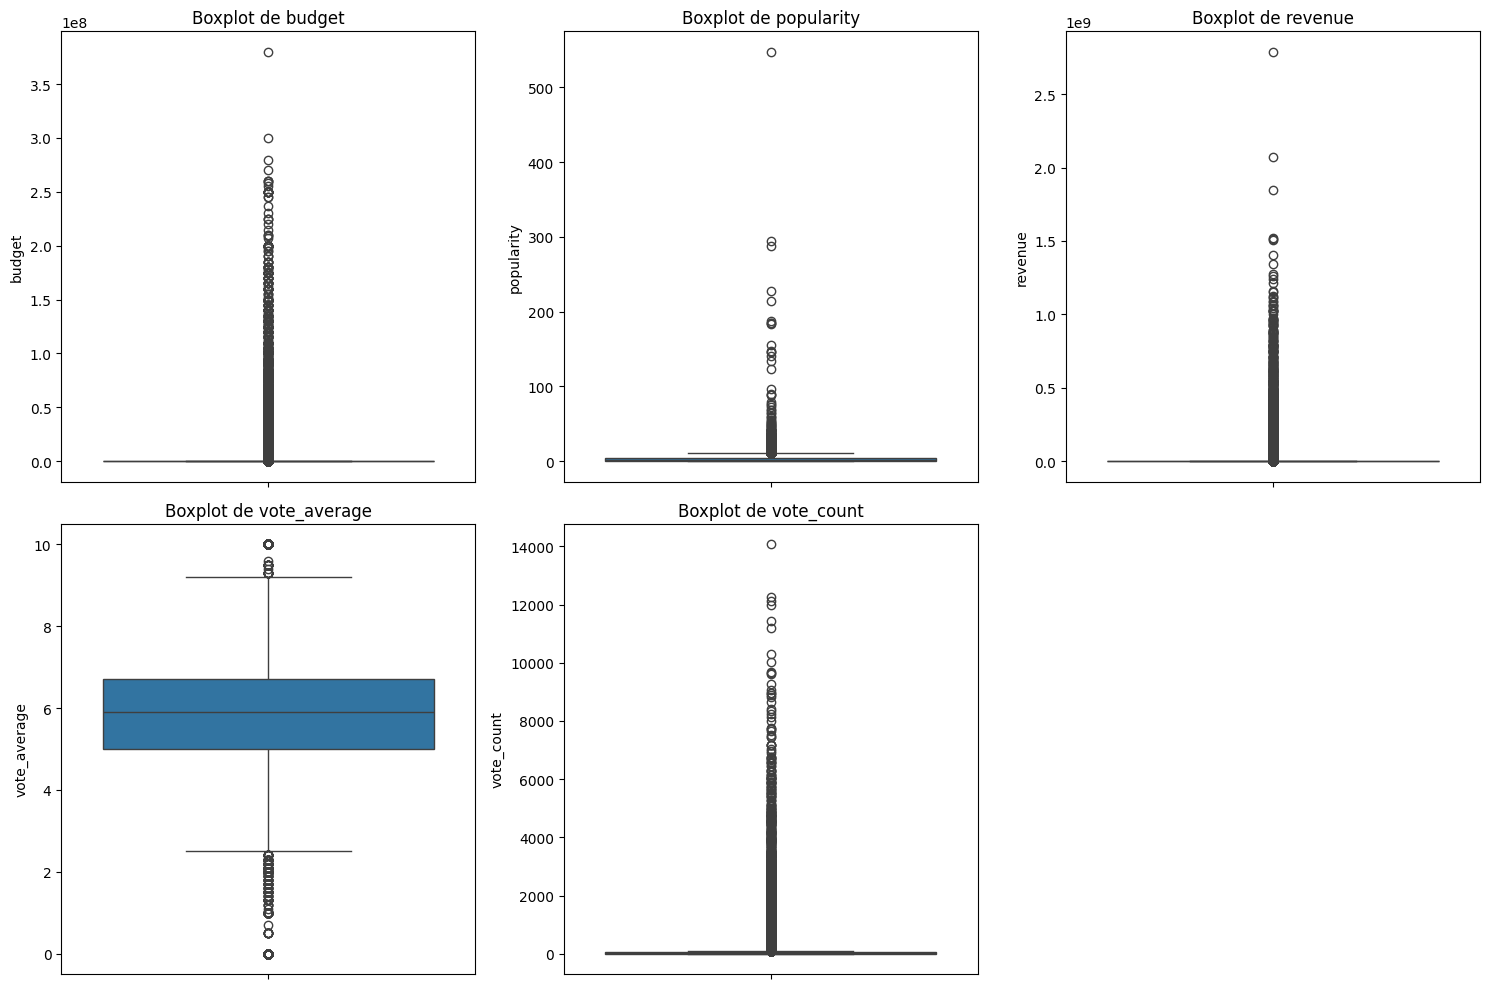

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = ['budget', 'popularity', 'revenue', 'vote_average', 'vote_count']

# Creamos un boxplot para cada columna numérica
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df_movies[column])
    plt.title(f"Boxplot de {column}")
plt.tight_layout()
plt.show()

In [18]:

# Detectamos outliers usando el rango intercuartílico (IQR)
outliers = {}
for column in numeric_columns:
    Q1 = df_movies[column].quantile(0.25)
    Q3 = df_movies[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[column] = df_movies[(df_movies[column] < lower_bound) | (df_movies[column] > upper_bound)][column]

# Mostramos el número de outliers por columna
for column, values in outliers.items():
    print(f"Outliers en {column}: {len(values)} valores")

Outliers en budget: 7537 valores
Outliers en popularity: 2050 valores
Outliers en revenue: 6445 valores
Outliers en runtime: 3738 valores
Outliers en vote_average: 2821 valores
Outliers en vote_count: 5271 valores


Con los graficos y cantidad de outliers vemos que en la mayoria de columnas vemos una gran concentración en valores bajos, a excepcion de vote_average, por lo que se observan muchos outliers hacia valores altos.

Pero dada la naturaleza del dataframe, que se trate de películas, esto es común ya que existen algunas películas que se destacan en popularidad, ingresos y presupuestos.

Ahora vamos a buscar la relacion entre popularity (nuestra variable principal para recomendación) y algunas variables numericas 

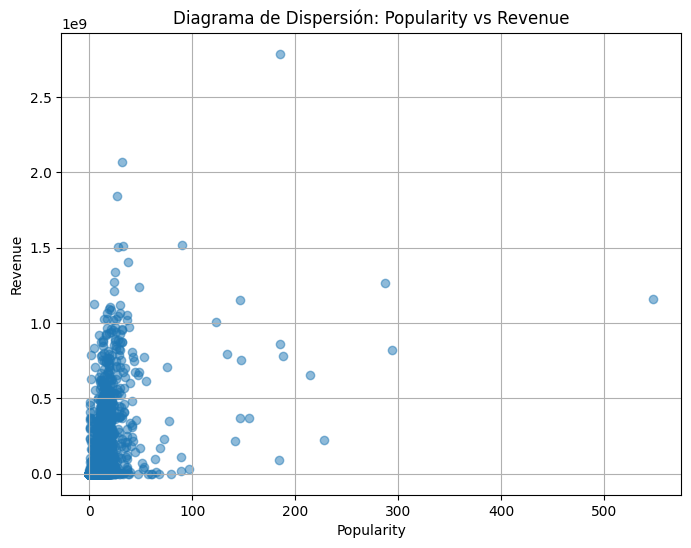

In [19]:
# Creamos un diagrama de dispersión entre popularity y revenue
plt.figure(figsize=(8, 6))
plt.scatter(df_movies['popularity'], df_movies['revenue'], alpha=0.5)
plt.title("Diagrama de Dispersión: Popularity vs Revenue")
plt.xlabel("Popularity")
plt.ylabel("Revenue")
plt.grid()
plt.show()

No se ve una clara correlacion entre la popularidad y las ganancias

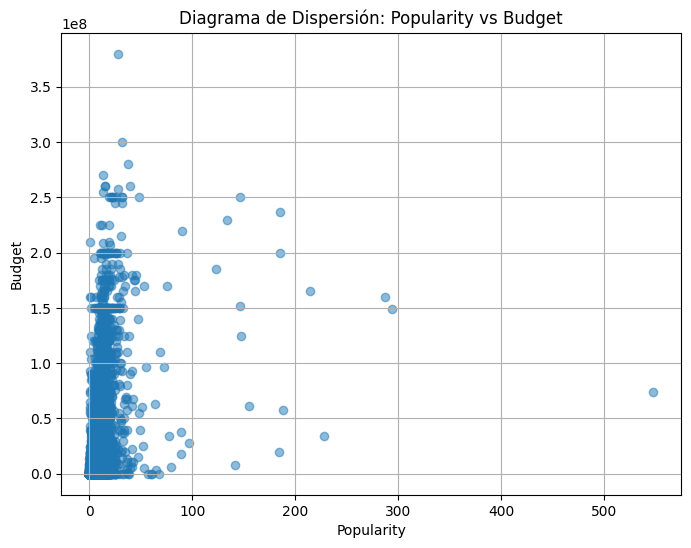

In [20]:
# Creamos un diagrama de dispersión entre popularity y budget
plt.figure(figsize=(8, 6))
plt.scatter(df_movies['popularity'], df_movies['budget'], alpha=0.5)
plt.title("Diagrama de Dispersión: Popularity vs Budget")
plt.xlabel("Popularity")
plt.ylabel("Budget")
plt.grid()
plt.show()

No se ve una correlacion directa entre la popularidad y el presupuesto

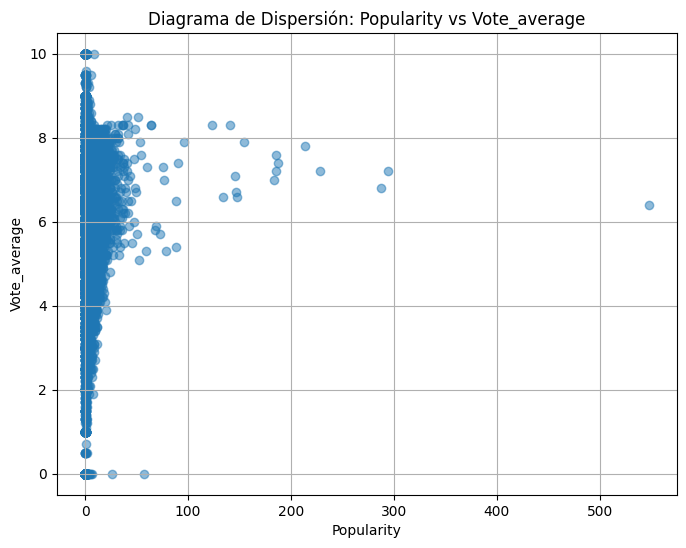

In [23]:
# Creamos un diagrama de dispersión entre popularity y vote_average
plt.figure(figsize=(8, 6))
plt.scatter(df_movies['popularity'], df_movies['vote_average'], alpha=0.5)
plt.title("Diagrama de Dispersión: Popularity vs Vote_average")
plt.xlabel("Popularity")
plt.ylabel("Vote_average")
plt.grid()
plt.show()

Aqui se esperaría que haya una correlacion entre popularidad y votos promedio, sin embargo vemos que la popularidad de una película no siempre está relacionada con su calificación.

Creo que ya analizamos las variables numericas que podrian tener relacion con la popularidad. Ahora vamos a explorar las variables de cadena. 

popularity         1.000000
Action             0.101033
Adventure          0.083400
Family             0.036532
Fantasy            0.031812
Science Fiction    0.030256
Animation          0.026378
Thriller           0.025751
Horror             0.014084
Crime              0.012682
Mystery            0.009406
History           -0.006876
Comedy            -0.007328
War               -0.008685
Romance           -0.012580
Drama             -0.014247
Western           -0.014842
Foreign           -0.016391
TV Movie          -0.017533
Music             -0.022843
Documentary       -0.110208
Name: popularity, dtype: float64


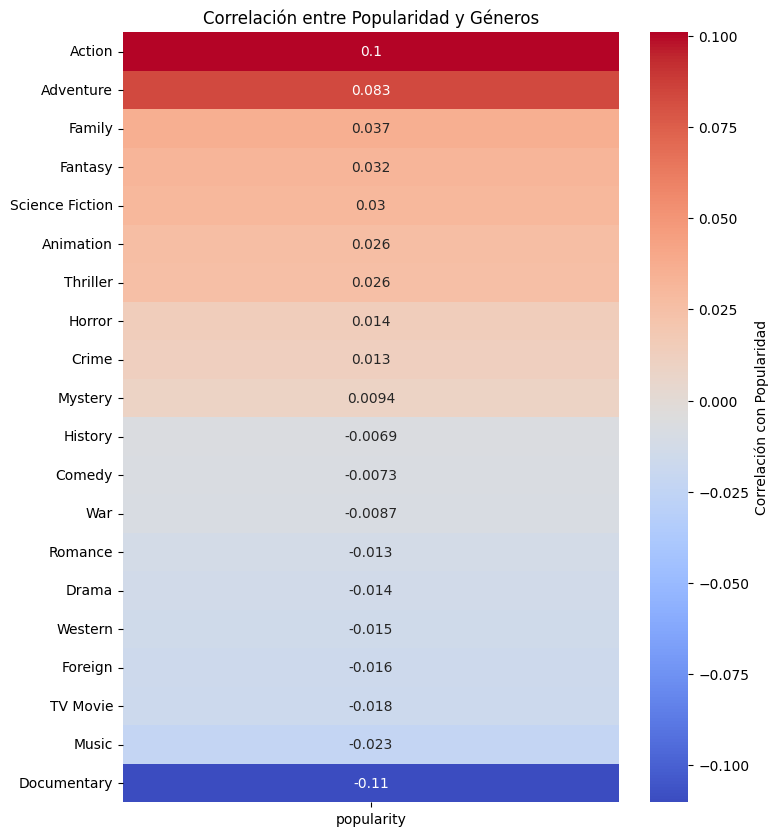

In [26]:

# Dividir los géneros y expandirlos a columnas binarias
df_genres = df_movies['genre'].str.get_dummies(sep='|')
df_popularity_genres = pd.concat([df_movies['popularity'], df_genres], axis=1)

# Calcular la correlación
correlations = df_popularity_genres.corr()['popularity'].sort_values(ascending=False)
print(correlations)

plt.figure(figsize=(8, 10))
sns.heatmap(correlations[1:].to_frame(), annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlación con Popularidad'})
plt.title('Correlación entre Popularidad y Géneros')
plt.show()

La mayoría de los géneros tienen una correlación muy baja con la popularidad. Por lo que el género de una película no tiene una gran influencia en su popularidad, al menos no en este dataset.

Pasamos a explorar el campo Overview. Vamos a transformar los datos para poder analizarlos.

Primero, creamos una nube de palabras para ver si hay palabras comunes y a traves de las mismas tambien podemos lograr identificar similitudes entre peliculas

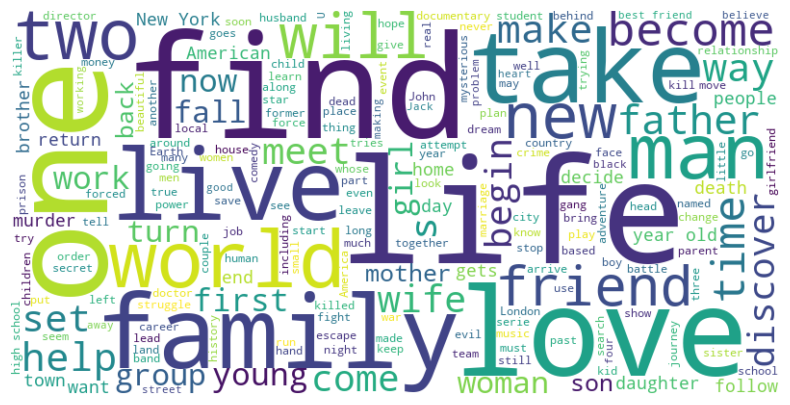

In [33]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Unir todos los textos de 'overview' en un solo string
text = " ".join(overview for overview in df_movies['overview'].dropna())

# Definir palabras irrelevantes
stopwords = set(STOPWORDS)
stopwords.update(["movie", "film", "story"])  # Puedes agregar más palabras aquí

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Vemos que existen palabras comunes destacadas entre las peliculas, esto puede aportar información útil para mejorar la recomendación.

Vamos a usar técnicas de procesamiento de lenguaje natural para convertir los overviews en vectores de características y luego incluirlos en el análisis de similitud.

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Nos asegurarmos de que la columna 'overview' no tenga valores nulos
df_movies['overview'] = df_movies['overview'].fillna('')

# Creamos el vectorizador TF-IDF (se eliminan las palabras comunes en inglés con 'stop_words')
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Transformamos los resúmenes en una matriz TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(df_movies['overview'])

# En la matriz TF-IDF cada fila representa una película y cada columna una palabra
print(f"Forma de la matriz TF-IDF: {tfidf_matrix.shape}")

# Calculamos la similitud de coseno entre los vectores de TF-IDF
overview_similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# La matriz de similitud tiene una forma de (n_películas, n_películas)
print(f"Forma de la matriz de similitud: {overview_similarity_matrix.shape}")

Forma de la matriz TF-IDF: (33176, 58806)
Forma de la matriz de similitud: (33176, 33176)


Luego utilizaremos esta matriz para la recomendación final

Ahora, calcularemos la matriz de similitud en base a la popularidad

In [36]:
from sklearn.preprocessing import MinMaxScaler

# Primero, normalizamos la columna 'popularity' entre 0 y 1
scaler = MinMaxScaler()
df_movies['popularity_normalized'] = scaler.fit_transform(df_movies[['popularity']])

In [49]:
# Crear la matriz de popularidad normalizada
matriz_normalizada_popularity = df_movies[['popularity_normalized']]

print(matriz_normalizada_popularity.head)

<bound method NDFrame.head of         popularity_normalized
0                    0.040087
3                    0.021394
7                    0.015320
9                    0.026824
45                   0.022175
...                       ...
419710               0.001208
419711               0.010382
419762               0.001649
419765               0.000006
419766               0.000298

[33176 rows x 1 columns]>


In [50]:
# Calcular la matriz de similitud de coseno
popularity_similarity_matrix = cosine_similarity(matriz_normalizada_popularity)

print(f"Forma de la matriz de similitud: {popularity_similarity_matrix.shape}")

Forma de la matriz de similitud: (33176, 33176)


In [39]:
# Asignamos pesos a cada matriz, aqui priorizamos popularidad, ya que es la consigna
weight_popularity = 0.7
weight_overview = 0.3

# Matriz combinada de similitud
combined_similarity_matrix = (weight_popularity * popularity_similarity_matrix) + (weight_overview * overview_similarity_matrix)

Como vemos, utilizar las dos variables para la recomendación hace que se lleve un tiempo considerable para el proceso, por lo que finalmente, por los recursos limitados que tendremos en nuestra herramienta (Render), utilizaremos solamente la matriz de popularidad.

In [42]:
def recomendacion(titulo):
    # Encontrar el índice de la película en el dataset
    movie_index = df_movies.index[df_movies['title'] == titulo].tolist()[0]
    
    # Obtener los puntajes de similitud para esa película específica
    similarity_scores = list(enumerate(popularity_similarity_matrix[movie_index]))
    
    # Ordenar las películas por similitud en orden descendente
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    
    # Seleccionar los índices de las películas más similares (excluyendo la misma película)
    top_movies_indices = [i[0] for i in similarity_scores[1:6]]
    
    # Obtener los títulos de las películas recomendadas
    recommended_titles = df_movies.iloc[top_movies_indices]['title'].tolist()
    
    return recommended_titles

In [45]:
#Probamos la funcion
titulo = 'Toy Story' 
recomendaciones = recomendacion(titulo)
print("Películas recomendadas:", recomendaciones)

Películas recomendadas: ['Grumpier Old Men', 'Father of the Bride Part II', 'GoldenEye', 'Balto', 'Ace Ventura: When Nature Calls']


Ahora hagamos una breve validacion de la recomendacion, verificando si las peliculas tienen un popularidad similar

In [46]:
print(f"Popularidad titulo principal: {df_movies[df_movies['title'] == titulo]['popularity'].values[0]}")

# Imprimir popularidad de cada recomendación
for title in recomendaciones:
    print(f"Recomendada: {title} - Popularidad: {df_movies[df_movies['title'] == title]['popularity'].values[0]}")

Popularidad titulo principal:21.946943
Recomendada: Grumpier Old Men - Popularidad: 11.7129
Recomendada: Father of the Bride Part II - Popularidad: 8.387519
Recomendada: GoldenEye - Popularidad: 14.686036
Recomendada: Balto - Popularidad: 12.140733
Recomendada: Ace Ventura: When Nature Calls - Popularidad: 8.205448


Nuestra funcion devuelve correctamente 5 peliculas con popularidad similar y en orden descendente. Ahora llevamos la logica de la funcion en el main, para lo cual, exportaremos los datos normalizados de popularity

In [51]:
import pyarrow as pa
import pyarrow.parquet as pq

matriz_normalizada_popularity_pa = pa.Table.from_pandas(matriz_normalizada_popularity)
pq.write_table(matriz_normalizada_popularity_pa, "matriz_normalizada_popularity.parquet")